# 고급통계적딥러닝 Final Project


---

# Spooky Author Identification 


*   Natural Language Preprocessing(NLP)
*   Data is from <https://www.kaggle.com/c/spooky-author-identification>



## Load pacakges

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import os, re
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize.toktok import ToktokTokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout, BatchNormalization, Bidirectional, LSTM, GRU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

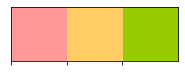

In [3]:
mycolors = ['#ff9999', '#ffcc66', '#99cc00']
sns.palplot(mycolors)

## Load and preview data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train = pd.read_csv('/content/drive/My Drive/spooky/train.csv',header=0)
test = pd.read_csv('/content/drive/My Drive/spooky/test.csv',header=0)
print(train.shape)
print(test.shape)

(19579, 3)
(8392, 2)


In [6]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


## Exploratory Data Analysis

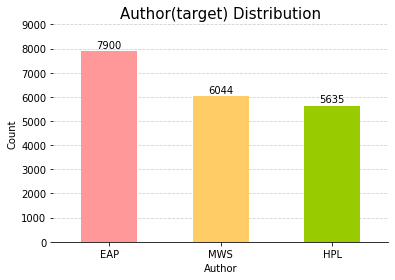

In [7]:
# target distribution
targets = train['author'].value_counts()
ax = targets.plot.bar(color = mycolors)

for i in range(3):
  plt.annotate(targets.values[i], xy = (i, targets.values[i] + 250), ha = 'center', va = 'center')

ax.set_xticklabels(targets.index, rotation = 0)
ax.set_ylim([0, 9000])
ax.set_xlabel('Author'); ax.set_ylabel('Count')
ax.set_title('Author(target) Distribution', fontsize = 15)

for i in ['left', 'right', 'top']:
  ax.spines[i].set_visible(False)

ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--', alpha = 0.6)

In [9]:
# text cleansing
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def text_cleansing(text):
  # 특수문자 제거
  tokens = text_to_word_sequence(text, filters = "[-=+,#/\?:^$.@*\"※~&%;ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]", lower = True, split = ' ')
  tokens = [token.strip() for token in tokens]
  new_tokens = [token for token in tokens if token not in stopwords]
  new_tokens_lem = []
  for word, tag in pos_tag(new_tokens):
        new_tag = tag[0].lower()
        new_tag = new_tag if new_tag in ['r', 'n', 'v', 'j'] else None
        lemma = lemmatizer.lemmatize(word, pos = new_tag) if new_tag in ['r','n','v'] else (lemmatizer.lemmatize(word, pos = 'a') if new_tag == 'j' else word) 
        new_tokens_lem.append(lemma)
  
  new_text = ' '.join(new_tokens_lem)
  return new_text

train['new_text'] = train['text'].apply(text_cleansing)
train.head()

,id,text,author,new_text
0,id26305,"This process, however, afforded me no means of...",EAP,process however afford mean ascertain dimensio...
1,id17569,It never once occurred to me that the fumbling...,HPL,never occur fumble might mere mistake
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,left hand gold snuff box caper hill cut manner...
3,id27763,How lovely is spring As we looked from Windsor...,MWS,lovely spring look windsor terrace sixteen fer...
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,find nothing else even gold superintendent aba...


In [10]:
from collections import Counter

eap = train[train['author'] == 'EAP']
eap_text = ' '.join(eap['new_text'])
eap_count = Counter(eap_text.split())
eap_count = dict(eap_count)
eap_count_df = pd.DataFrame({'word': eap_count.keys(), 'freq': eap_count.values()}).sort_values(by = 'freq', ascending = False)
eap_top50 = eap_count_df[:50]

In [11]:
# define plot function
def plot_word_dist(data, color):
  fig, (ax1, ax2)  = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 4))
  ax1.hist(data['freq'], color = color, bins = 50, edgecolor = 'lightgrey')
  ax1.set_title('Word Frequency Distribution', fontsize = 15); ax1.set_xlabel('Frequency')
  sns.barplot(data.word, data.freq, ax = ax2, color = '#33cccc')
  ax2.set_title('Frequency of Words', fontsize = 15); ax2.set_xlabel('Word'); ax2.set_xticklabels(labels = data['word'], rotation = 45)
  ax2.set_ylabel('Frequency')

  for i in ['left', 'right', 'top']:
    ax1.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)

  ax1.set_axisbelow(True)
  ax1.grid(axis='y', linestyle='--', alpha = 0.6)

  ax2.set_axisbelow(True)
  ax2.grid(axis='y', linestyle='--', alpha = 0.6)

  plt.show()

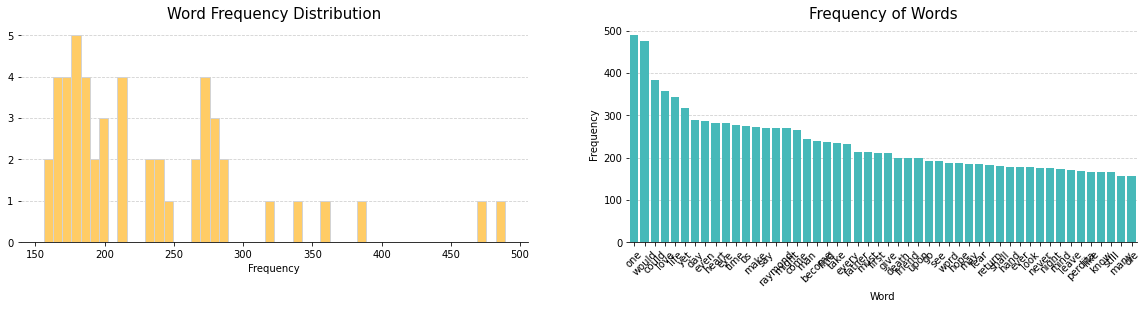

In [12]:
mws = train[train['author'] == 'MWS']
mws_text = ' '.join(mws['new_text'])
mws_count = Counter(mws_text.split())
mws_count = dict(mws_count)
mws_count_df = pd.DataFrame({'word': mws_count.keys(), 'freq': mws_count.values()}).sort_values(by = 'freq', ascending = False)
mws_top50 = mws_count_df[:50]

plot_word_dist(mws_top50, '#ffcc66')

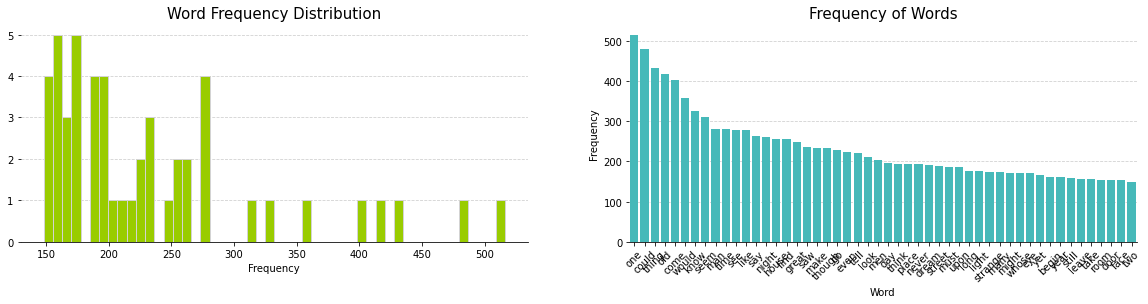

In [13]:
hpl = train[train['author'] == 'HPL']
hpl_text = ' '.join(hpl['new_text'])
hpl_count = Counter(hpl_text.split())
hpl_count = dict(hpl_count)
hpl_count_df = pd.DataFrame({'word': hpl_count.keys(), 'freq': hpl_count.values()}).sort_values(by = 'freq', ascending = False)
hpl_top50 = hpl_count_df[:50]

plot_word_dist(hpl_top50, mycolors[2])

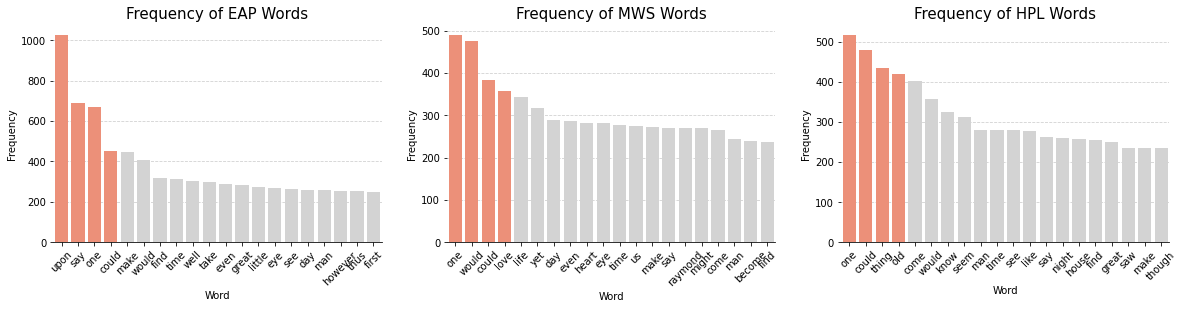

In [14]:
fig, (ax1, ax2, ax3)  = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 4))

colors = ['lightgrey']*20
for i in range(4):
  colors[i] = '#ff8566'

sns.barplot(eap_top50[:20].word, eap_top50[:20].freq, ax = ax1, palette = colors)

ax1.set_title('Frequency of EAP Words', fontsize = 15); ax1.set_xlabel('Word'); ax1.set_xticklabels(labels = eap_top50['word'], rotation = 45)
ax1.set_ylabel('Frequency')

sns.barplot(mws_top50[:20].word, mws_top50[:20].freq, ax = ax2, palette = colors)
ax2.set_title('Frequency of MWS Words', fontsize = 15); ax2.set_xlabel('Word'); ax2.set_xticklabels(labels = mws_top50['word'], rotation = 45)
ax2.set_ylabel('Frequency')

sns.barplot(hpl_top50[:20].word, hpl_top50[:20].freq, ax = ax3, palette = colors)
ax3.set_title('Frequency of HPL Words', fontsize = 15); ax3.set_xlabel('Word'); ax3.set_xticklabels(labels = hpl_top50['word'], rotation = 45)
ax3.set_ylabel('Frequency')

for i in ['left', 'right', 'top']:
    ax1.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    ax3.spines[i].set_visible(False)

ax1.set_axisbelow(True)
ax1.grid(axis='y', linestyle='--', alpha = 0.6)

ax2.set_axisbelow(True)
ax2.grid(axis='y', linestyle='--', alpha = 0.6)

ax3.set_axisbelow(True)
ax3.grid(axis='y', linestyle='--', alpha = 0.6)

plt.show()

In [15]:
# delete 'could', 'would', 'one'
del(eap_count['could'])
del(eap_count['would'])
del(eap_count['one'])

del(mws_count['could'])
del(mws_count['would'])
del(mws_count['one'])

del(hpl_count['could'])
del(hpl_count['would'])
del(hpl_count['one'])

In [16]:
def eap_colors(word, font_size, position, orientation, random_state = None, **kwargs):
    return("hsl({:d}, {:d}%, {:d}%)".format(np.random.randint(0, 50), np.random.randint(100, 130), np.random.randint(70, 110)))

def mws_colors(word, font_size, position, orientation, random_state = None, **kwargs):
    return("hsl({:d}, {:d}%, {:d}%)".format(np.random.randint(40, 80), np.random.randint(100, 140), np.random.randint(40, 100)))

def hpl_colors(word, font_size, position, orientation, random_state = None, **kwargs):
    return("hsl({:d}, {:d}%, {:d}%)".format(np.random.randint(70, 100), np.random.randint(90, 120), np.random.randint(30, 80)))

In [17]:
mask_img = np.array(Image.open('/content/drive/My Drive/spooky/cloud.png'))

wc1 = WordCloud(max_font_size = 150, 
                stopwords = stopwords, 
                background_color = 'black', 
                width = 800, 
                height = 800,
                mask = mask_img,
                contour_color = '#ff9999',
                contour_width = 3)

wc1.generate_from_frequencies(eap_count)
wc1 = wc1.recolor(color_func = eap_colors, random_state = True) 

wc2 = WordCloud(max_font_size = 150, 
                stopwords = stopwords, 
                background_color = 'black', 
                width = 800, 
                height = 800,
                mask = mask_img,
                contour_color = mycolors[1],
                contour_width = 3)

wc2.generate_from_frequencies(mws_count)
wc2 = wc2.recolor(color_func = mws_colors, random_state = True) 

wc3 = WordCloud(max_font_size = 150, 
                stopwords = stopwords, 
                background_color = 'black', 
                width = 800, 
                height = 800,
                mask = mask_img,
                contour_color = mycolors[2],
                contour_width = 3)

wc3.generate_from_frequencies(hpl_count)
wc3 = wc3.recolor(color_func = hpl_colors, random_state = True) 

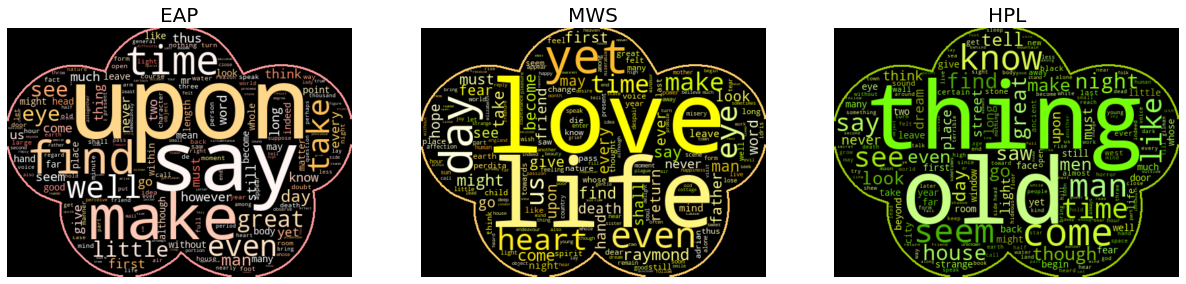

In [18]:
plt.figure(figsize = (21, 7))

plt.subplot(1, 3, 1)
plt.imshow(wc1, interpolation = 'bilinear')
plt.title('EAP', fontsize = 20)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(wc2, interpolation = 'bilinear')
plt.title('MWS', fontsize = 20)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(wc3, interpolation = 'bilinear')
plt.title('HPL', fontsize = 20)
plt.axis('off')

plt.show()

## Text Preprocessing

In [ ]:
# text cleansing
stopwords = nltk.corpus.stopwords.words('english')
more_words = ['one', 'would', 'could']
for w in more_words:
    stopwords.append(w)

lemmatizer = WordNetLemmatizer()

def text_cleansing(text):
  # 특수문자 제거
    tokens = text_to_word_sequence(text, filters = "[-=+,#/\?:^$.@*\"※~&%;ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]", lower = True, split = ' ')
    tokens = [token.strip() for token in tokens]
    new_tokens = [token for token in tokens if token not in stopwords]
    new_tokens_lem = []
    for word, tag in pos_tag(new_tokens):
        new_tag = tag[0].lower()
        new_tag = new_tag if new_tag in ['r', 'n', 'v', 'j'] else None
        lemma = lemmatizer.lemmatize(word, pos = new_tag) if new_tag in ['r','n','v'] else (lemmatizer.lemmatize(word, pos = 'a') if new_tag == 'j' else word) 
        new_tokens_lem.append(lemma)
  
    new_text = ' '.join(new_tokens_lem)
    return new_text

train['new_text'] = train['text'].apply(text_cleansing)
train.head()

In [ ]:
maxlen = 100

tokenizer = Tokenizer(num_words = None)
tokenizer.fit_on_texts(list(train['new_text'].values))

train_sequence = tokenizer.texts_to_sequences(train['new_text'].values)
train_data = pad_sequences(train_sequence, maxlen = maxlen)

In [ ]:
embedding_idx = {}
f = open('glove.42B.300d.txt', encoding = 'utf-8')
for line in f:
    values = line.split()
    word = values[0]
    seq = np.asarray(values[1:], dtype='float32')
    embedding_idx[word] = seq
f.close()

In [ ]:
max_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((max_words, 300))
for word, i in tokenizer.word_index.items():
    if word in embedding_idx:
        embedding_vector = embedding_idx.get(word)
        embedding_matrix[i] = embedding_vector

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_label = encoder.fit_transform(train['author'])
y = to_categorical(y_label)

## NLP Model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_data, y, test_size = 0.2, random_state = 0)

In [ ]:
####### model 1 ##########
embedding_dim = 300

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))

model.add(Bidirectional(LSTM(256, dropout=0.5, recurrent_dropout=0.3, return_sequences = True)))
model.add(Bidirectional(LSTM(256, dropout=0.5, recurrent_dropout=0.3)))

model.add(Dense(64, activation='relu', kernel_initializer = 'he_normal'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation = 'softmax'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
es = EarlyStopping(monitor = 'val_loss', patience = 3)
rp = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics =  ['acc'])

result = model.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val), callbacks = [es, rp])

In [ ]:
epochs = result2.epoch
epochs = [i+1 for i in epochs]


plt.figure(figsize = (10, 4))

ax1 = plt.subplot(1, 2, 1)
sns.lineplot(epochs, result.history['loss'], color = 'green', label = 'Train')
sns.scatterplot(epochs, result.history['val_loss'], color = 'red', label = 'Validation')
plt.title('Train loss vs Validation loss', fontsize = 15);plt.xlabel('Epoch');plt.ylabel('Loss')
for i in ['left', 'right', 'top']:
    ax1.spines[i].set_visible(False)

ax1.set_axisbelow(True)
ax1.grid(axis='y', linestyle='--', alpha = 0.6)

ax2 = plt.subplot(1, 2, 2)
sns.lineplot(epochs, result.history['acc'], color = 'green', label = 'Train')
sns.scatterplot(epochs, result.history['val_acc'], color = 'red', label = 'Validation')
plt.title('Train accuracy vs Validation accuray', fontsize = 15); plt.ylim([0.55, 1]);plt.xlabel('Epoch');plt.ylabel('Accuracy')
for i in ['left', 'right', 'top']:
    ax2.spines[i].set_visible(False)

ax2.set_axisbelow(True)
ax2.grid(axis='y', linestyle='--', alpha = 0.6)

plt.tight_layout()
plt.show()

In [ ]:
####### model 2 ##########
embedding_dim = 300

model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length = maxlen))

model2.add(LSTM(256, dropout=0.5, recurrent_dropout=0.3, return_sequences = True))
model2.add(LSTM(128, dropout=0.5, recurrent_dropout=0.3))

model2.add(Dense(64, activation='relu', kernel_initializer = 'he_normal'))
model2.add(Dropout(0.5))

model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(3, activation = 'softmax'))

model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

In [ ]:
####### model 3 ##########
embedding_dim = 300

model3 = Sequential()
model3.add(Embedding(max_words, embedding_dim, input_length = maxlen))

model3.add(LSTM(256, dropout=0.5, recurrent_dropout=0.3))

model3.add(Dense(64, activation='relu', kernel_initializer = 'he_normal'))
model3.add(Dropout(0.5))

model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(3, activation = 'softmax'))

model3.layers[0].set_weights([embedding_matrix])
model3.layers[0].trainable = False